In [1]:
import sys, os 
if 'src' not in sys.path:
    sys.path.append('src')
    
from scipy.stats import spearmanr,pearsonr,gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
from tqdm import tqdm
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
def get_dist_start_correlation(cell_line, v2, unseen=True, smooth=True, res=5000):

    if v2:
        results = np.load(f'../results/{cell_line}/paper-hg38-map-concat-stage1024-rf-lrelu-eval-stg-newsplit-newdata-atac-var-beta-neg-swap-s1337/results.npz')
    else:
        results = np.load(f'../results/{cell_line}/paper-hg38-map-concat-stage1024-rf-lrelu-eval-stg-newsplit-newdata-atac-var-beta-neg-s1337/results.npz')

    pred_dim = 200
    res = 5000

    predictions = np.reshape(results['predictions'], [-1, pred_dim])
    predictions = np.clip(predictions, 0, None)
    targets = np.reshape(results['targets'], [-1, pred_dim])
    
    chr_data = results['chr_data']
    pos1 = results['pos1']//res
    pos2 = results['pos2']//res

    tmp_df = pd.DataFrame({
        'chr': chr_data.flatten(),
        'pos1': pos1.flatten(),
        'pos2': pos2.flatten(),
        'target': targets.flatten(),
        'preds': predictions.flatten()
    })
    tmp_df['dist'] = abs(tmp_df['pos1']-tmp_df['pos2'])

    df_mix = tmp_df
    unmap = pd.read_csv("../blacklist/basenji_unmappable.bed", sep="\t", names=["chr", "start", "end"])
    test_chr = ["chr2", "chr19", "chr6"]
    unmap = unmap[unmap.chr.isin(test_chr)]
    drop_info = {}
    for chr in test_chr:
        unmap_chr = unmap[unmap.chr == chr]
        chr = int(chr.split("chr")[-1])
        drop_list = []
        for _,row in tqdm(unmap_chr.iterrows()):
            start = row['start']
            end = row['end']
            skip_regions = []
            i = start
            while i<=end:
                skip_regions.append(i//5000)
                i+=5000
            drop_list.extend(skip_regions)
        drop_info[chr] = drop_list

    final_df = []
    for chr, drop_list in drop_info.items():
        df_filter = df_mix[df_mix.chr==chr]
        df_filter = df_filter[~df_filter.pos1.isin(drop_list)]
        df_filter = df_filter[~df_filter.pos2.isin(drop_list)]
        final_df.append(df_filter)
    final_df = pd.concat(final_df, ignore_index=True)
    
    unmap = pd.read_csv("../blacklist/basenji_blacklist.bed", sep="\t", names=["chr", "start", "end"])
    test_chr = ["chr2", "chr19", "chr6"]
    unmap = unmap[unmap.chr.isin(test_chr)]
    drop_info = {}
    for chr in test_chr:
        unmap_chr = unmap[unmap.chr == chr]
        chr = int(chr.split("chr")[-1])
        drop_list = []
        for _,row in tqdm(unmap_chr.iterrows()):
            start = row['start']
            end = row['end']
            skip_regions = []
            i = start
            while i<=end:
                skip_regions.append(i//5000)
                i+=5000
            drop_list.extend(skip_regions)
        drop_info[chr] = drop_list

    df_list = []
    for chr, drop_list in drop_info.items():
        df_filter = final_df[final_df.chr==chr]
        df_filter = df_filter[~df_filter.pos1.isin(drop_list)]
        df_filter = df_filter[~df_filter.pos2.isin(drop_list)]
        df_list.append(df_filter)
    final_df = pd.concat(df_list, ignore_index=True)

    # Remove cell-type-specific blacklisted regions
    blacklist = pd.read_csv(f"../blacklist/{cell_line.lower()}_blacklist.bed", sep="\t", names=["chr", "start", "end"])
    test_chr = ["chr2", "chr19", "chr6"]
    blacklist = blacklist[blacklist.chr.isin(test_chr)]
    drop_info = {}
    for chr in test_chr:
        blacklist_chr = blacklist[blacklist.chr == chr]
        chr = int(chr.split("chr")[-1])
        blacklist_chr['bin1'] = blacklist_chr.start//5000
        if smooth:
            drop_list = []
            for _,row in tqdm(blacklist_chr.iterrows()):
                start = row['bin1']
                skip_regions = [start, start+1, start-1]
                drop_list.extend(skip_regions)
        else:
            drop_list = blacklist_chr.bin1.to_list()
        drop_info[chr] = drop_list

    df_list = []
    for chr, drop_list in drop_info.items():
        df_filter = final_df[final_df.chr==chr]
        df_filter = df_filter[~df_filter.pos1.isin(drop_list)]
        df_filter = df_filter[~df_filter.pos2.isin(drop_list)]
        df_list.append(df_filter)
    final_df = pd.concat(df_list, ignore_index=True)

    return final_df

In [3]:
res = 5000
cell_lines = ['gm12878', 'k562', 'imr90', 'hepg2']
unseen = True
cell_line_list = []
x_list = []
score_list = []
pred_list = []
for cell_line in cell_lines:
    print(f'Processing {cell_line}...')
    if cell_line == 'gm12878' or cell_line == 'k562':
        if unseen:
            final_df = get_dist_start_correlation(cell_line, v2=True, res=res, unseen=True)
        else:
            final_df = get_dist_start_correlation(cell_line, v2=False, res=res, unseen=False)
    else:
        if unseen:
            final_df = get_dist_start_correlation(cell_line, v2=False, res=res, unseen=True)
        else:    
            final_df = get_dist_start_correlation(cell_line, v2=True, res=res, unseen=False)
    
    for index in range(np.uint(2000000/res)):
        df_pos = final_df[(final_df.dist==index)]
        rho, _ = spearmanr(np.array(df_pos['target'].values.tolist()), np.array(df_pos['preds'].values.tolist()))
        score_list.append(rho)
        x_list.append(index)
        cell_line_list.append(cell_line)
        pred_list.append(np.mean(df_pos['preds'].values.tolist()))

Processing gm12878...


114616it [00:03, 35044.91it/s]
46535it [00:01, 36278.21it/s]
78231it [00:01, 42191.41it/s]
183it [00:00, 11256.82it/s]
869it [00:00, 41349.68it/s]
73it [00:00, 34267.96it/s]
<ipython-input-2-e97bf5ecb8e5>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blacklist_chr['bin1'] = blacklist_chr.start//5000
1827it [00:00, 46793.48it/s]
349it [00:00, 47566.52it/s]
1238it [00:00, 47103.07it/s]


Processing k562...


114616it [00:02, 45200.79it/s]
46535it [00:01, 43858.74it/s]
78231it [00:01, 45458.14it/s]
183it [00:00, 16273.88it/s]
869it [00:00, 35340.92it/s]
73it [00:00, 34695.09it/s]
1049it [00:00, 48596.44it/s]
340it [00:00, 45284.79it/s]
645it [00:00, 48048.56it/s]


Processing imr90...


114616it [00:02, 45584.98it/s]
46535it [00:01, 45848.50it/s]
78231it [00:01, 45811.39it/s]
183it [00:00, 15242.63it/s]
869it [00:00, 42784.95it/s]
73it [00:00, 37730.65it/s]
2662it [00:00, 49509.08it/s]
585it [00:00, 46469.22it/s]
2015it [00:00, 49022.18it/s]


Processing hepg2...


114616it [00:02, 41083.77it/s]
46535it [00:01, 43357.10it/s]
78231it [00:01, 45067.60it/s]
183it [00:00, 26109.18it/s]
869it [00:00, 43109.32it/s]
73it [00:00, 38082.61it/s]
2551it [00:00, 49725.43it/s]
316it [00:00, 45390.41it/s]
1369it [00:00, 48508.11it/s]


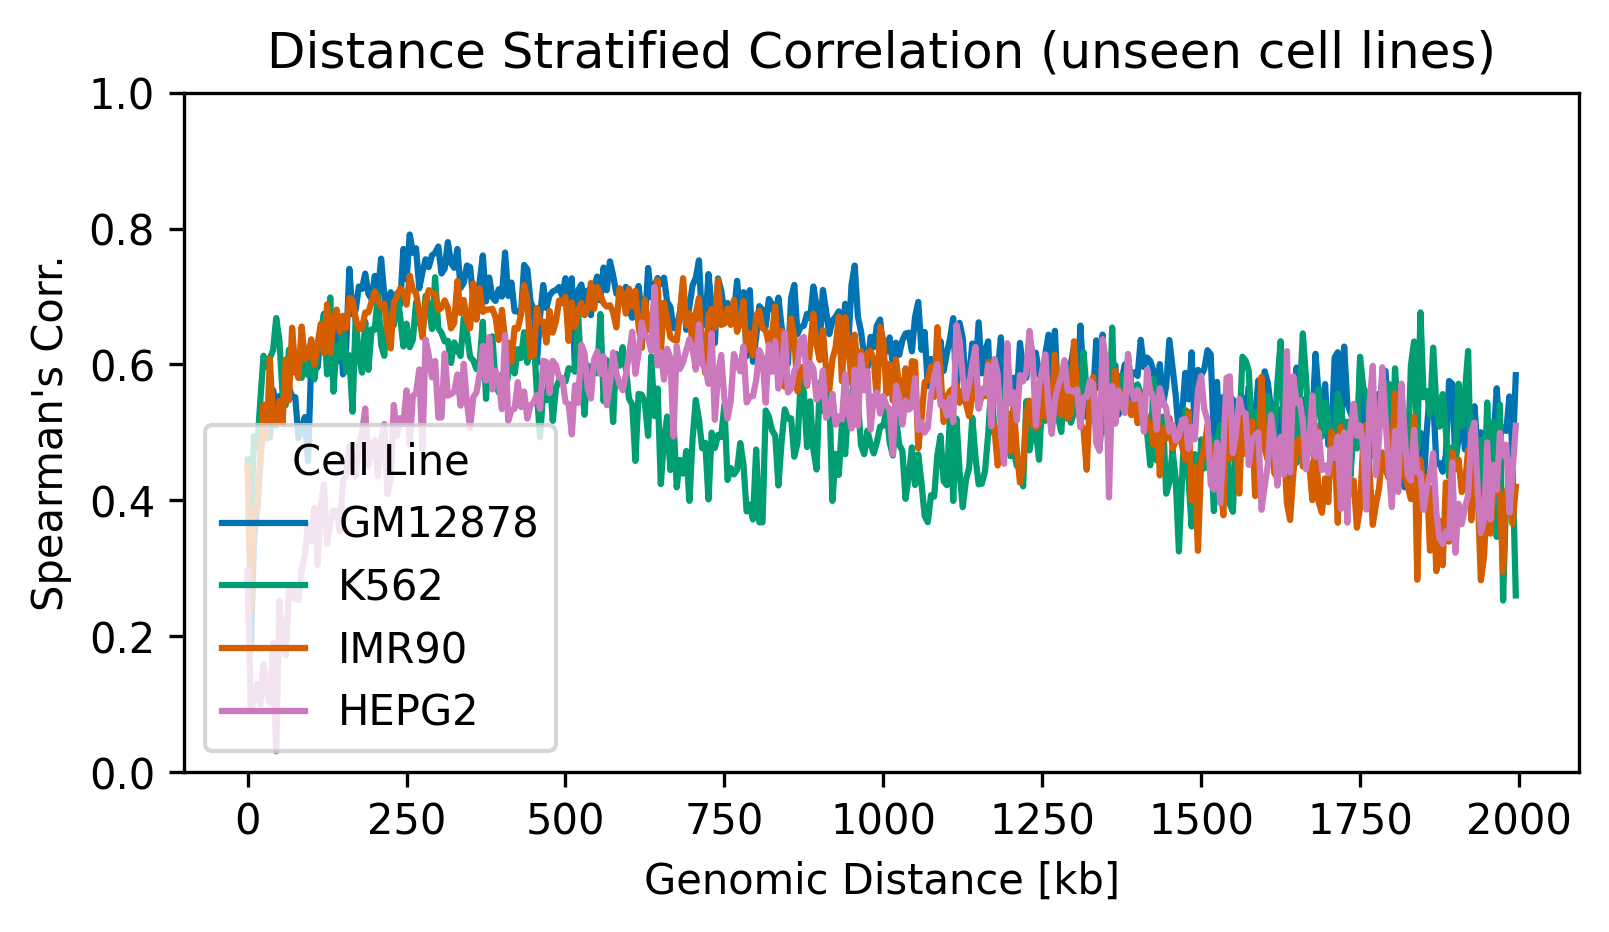

In [4]:
cell_line_list = [x.upper() for x in cell_line_list]

df = pd.DataFrame({
    'Cell Line': cell_line_list,
    'Genomic Distance [kb]': x_list,
    "Spearman's Corr.": score_list
})
df['Genomic Distance [kb]'] = df['Genomic Distance [kb]'].apply(lambda x: x*res/1000)

sns.set_palette("colorblind6")
f, ax = plt.subplots(1,1,figsize=(6, 3),dpi=300)
sns.lineplot(data=df, x='Genomic Distance [kb]', y="Spearman's Corr.", hue='Cell Line', ax=ax)
ax.set_ylim(0, 1)
title = 'Distance Stratified Correlation (unseen cell lines)' if unseen else 'Distance Stratified Correlation (within cell lines)'
plt.title(title)
plt.savefig(f'./plots/distance_stratified_correlation_unseen={unseen}_unit_test.svg', format='svg', transparent=True)

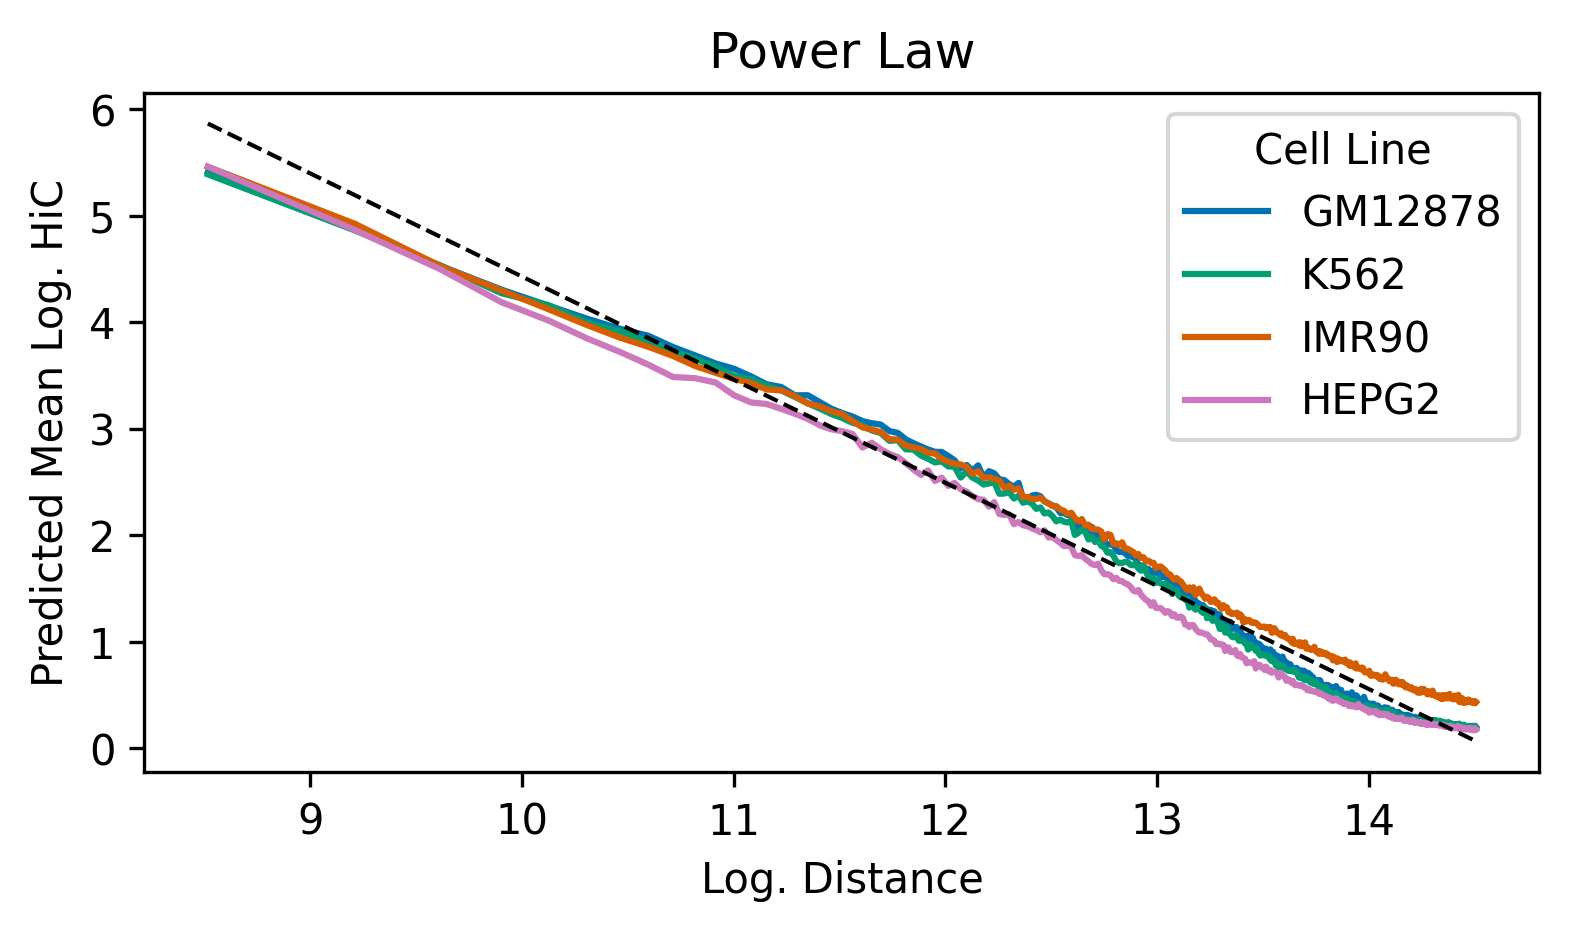

In [5]:
cell_line_list = [x.upper() for x in cell_line_list]
df = pd.DataFrame({
    'Cell Line': cell_line_list,
    'Genomic Distance [kb]': x_list,
    "Predicted Mean Log. HiC": pred_list,
})
df['Log. Distance'] = np.log((df['Genomic Distance [kb]']*res)+1)
df = df[df['Log. Distance'] > 0]
m,c = np.polyfit(df['Log. Distance'], df["Predicted Mean Log. HiC"], 1)
y = m*df['Log. Distance'] + c
f, ax = plt.subplots(1,1,figsize=(6, 3),dpi=300)
sns.lineplot(data=df, x='Log. Distance', y="Predicted Mean Log. HiC", hue='Cell Line', ax=ax)
plt.plot(df['Log. Distance'], y, color='black', linestyle='--', linewidth=1)
title = 'Power Law'
plt.title(title)
plt.savefig(f'./plots/power_law_unit_test.svg', format='svg', transparent=True)

In [6]:
cell_lines = ['gm12878', 'k562', 'imr90', 'hepg2']
def get_pred(df):
    pred_list = []
    seen_starts = []
    seen_ends = []
    seen_chrs = []
    for row in tqdm(df.itertuples(), total=df.shape[0]):
        output = row.output
        start = row.start
        end = row.end
        chr = row.chr
        if (start in seen_starts) and (end in seen_ends) and (chr in seen_chrs):
            continue
        end = row.end
        bin1 = [x[0] for x in output]
        bin2 = [x[1] for x in output]
        pred = [np.exp(x[2])-1 for x in output]
        pred_score = [pred[i] for i in range(len(bin1)) if bin1[i] == start and bin2[i] == end]
        if len(pred_score) == 0:
            continue
        if len(pred_score) > 1:
            print('Error')
        pred_list.append(pred_score[0])
        seen_starts.append(start)
        
    return pred_list

cell_line_list = []
fc_list = []
modes = ['train', 'val', 'test']
for cell_line in cell_lines:
    for mode in modes:
        print(f'Processing {cell_line} ({mode})...')
        mut = pd.read_hdf(f'./results/ism/ism_all_interactions_{cell_line}_{mode}_atac_updated_stage1_mutated_s1337.h5', key='df')
        wt = pd.read_hdf(f'./results/ism/ism_all_interactions_{cell_line}_{mode}_atac_updated_stage1_normal_s1337.h5', key='df')
        print(wt.drop_duplicates(['chr', 'start', 'end']).shape)
        score_mut = get_pred(mut)
        print(len(score_mut))
        score_wt = get_pred(wt)

        logfc = np.log2(np.array(score_mut)+1) - np.log2(np.array(score_wt)+1)
        fc_list.extend(logfc)
        cell_line_list.extend([cell_line.upper()]*len(logfc))

df = pd.DataFrame({
    'Cell Line': cell_line_list,
    'Log2FC(mut/ref)': fc_list
})
counts_map = df.groupby('Cell Line').size().to_dict()
df['Cell Line'] = df['Cell Line'].apply(lambda x: f'{x}\n(n={counts_map[x]})')

Processing gm12878 (train)...


  1%|          | 100/10278 [00:00<00:10, 991.55it/s]

(41, 6)


  1%|          | 116/10278 [00:00<00:08, 1156.42it/s]

29


  7%|▋         | 117/1754 [00:00<00:01, 1168.17it/s]

Processing gm12878 (val)...
(6, 6)


  7%|▋         | 115/1754 [00:00<00:01, 1143.76it/s]

5


  0%|          | 0/6120 [00:00<?, ?it/s]

Processing gm12878 (test)...
(24, 6)


  4%|▍         | 230/6120 [00:00<00:05, 1143.19it/s]

17


100%|██████████| 6120/6120 [00:05<00:00, 1121.03it/s]


Processing k562 (train)...


  0%|          | 109/23059 [00:00<00:21, 1082.55it/s]

(104, 6)


  0%|          | 115/23059 [00:00<00:20, 1143.97it/s]

64


  0%|          | 0/1544 [00:00<?, ?it/s]

Processing k562 (val)...
(8, 6)


 15%|█▍        | 229/1544 [00:00<00:01, 1143.49it/s]

4


100%|██████████| 1544/1544 [00:01<00:00, 1147.14it/s]


Processing k562 (test)...


  1%|          | 110/13926 [00:00<00:13, 1047.34it/s]

(46, 6)


  1%|          | 115/13926 [00:00<00:12, 1143.24it/s]

37


100%|██████████| 13926/13926 [00:12<00:00, 1142.22it/s]


Processing imr90 (train)...


  1%|          | 115/16095 [00:00<00:13, 1143.87it/s]

(71, 6)


  1%|          | 115/16095 [00:00<00:13, 1148.68it/s]

52


  4%|▍         | 116/2611 [00:00<00:02, 1150.52it/s]

Processing imr90 (val)...
(13, 6)


  8%|▊         | 200/2611 [00:00<00:02, 1019.77it/s]

8


  0%|          | 0/5582 [00:00<?, ?it/s]

Processing imr90 (test)...
(20, 6)


  2%|▏         | 116/5582 [00:00<00:04, 1152.13it/s]

15


100%|██████████| 5582/5582 [00:04<00:00, 1149.49it/s]


Processing hepg2 (train)...


  1%|          | 113/13347 [00:00<00:11, 1124.75it/s]

(63, 6)


  2%|▏         | 228/13347 [00:00<00:11, 1137.66it/s]

34


  3%|▎         | 117/3609 [00:00<00:03, 1163.09it/s]

Processing hepg2 (val)...
(17, 6)


  3%|▎         | 116/3609 [00:00<00:03, 1156.66it/s]

10


  0%|          | 0/6966 [00:00<?, ?it/s]

Processing hepg2 (test)...
(29, 6)


  2%|▏         | 115/6966 [00:00<00:05, 1142.82it/s]

18


100%|██████████| 6966/6966 [00:06<00:00, 1142.99it/s]


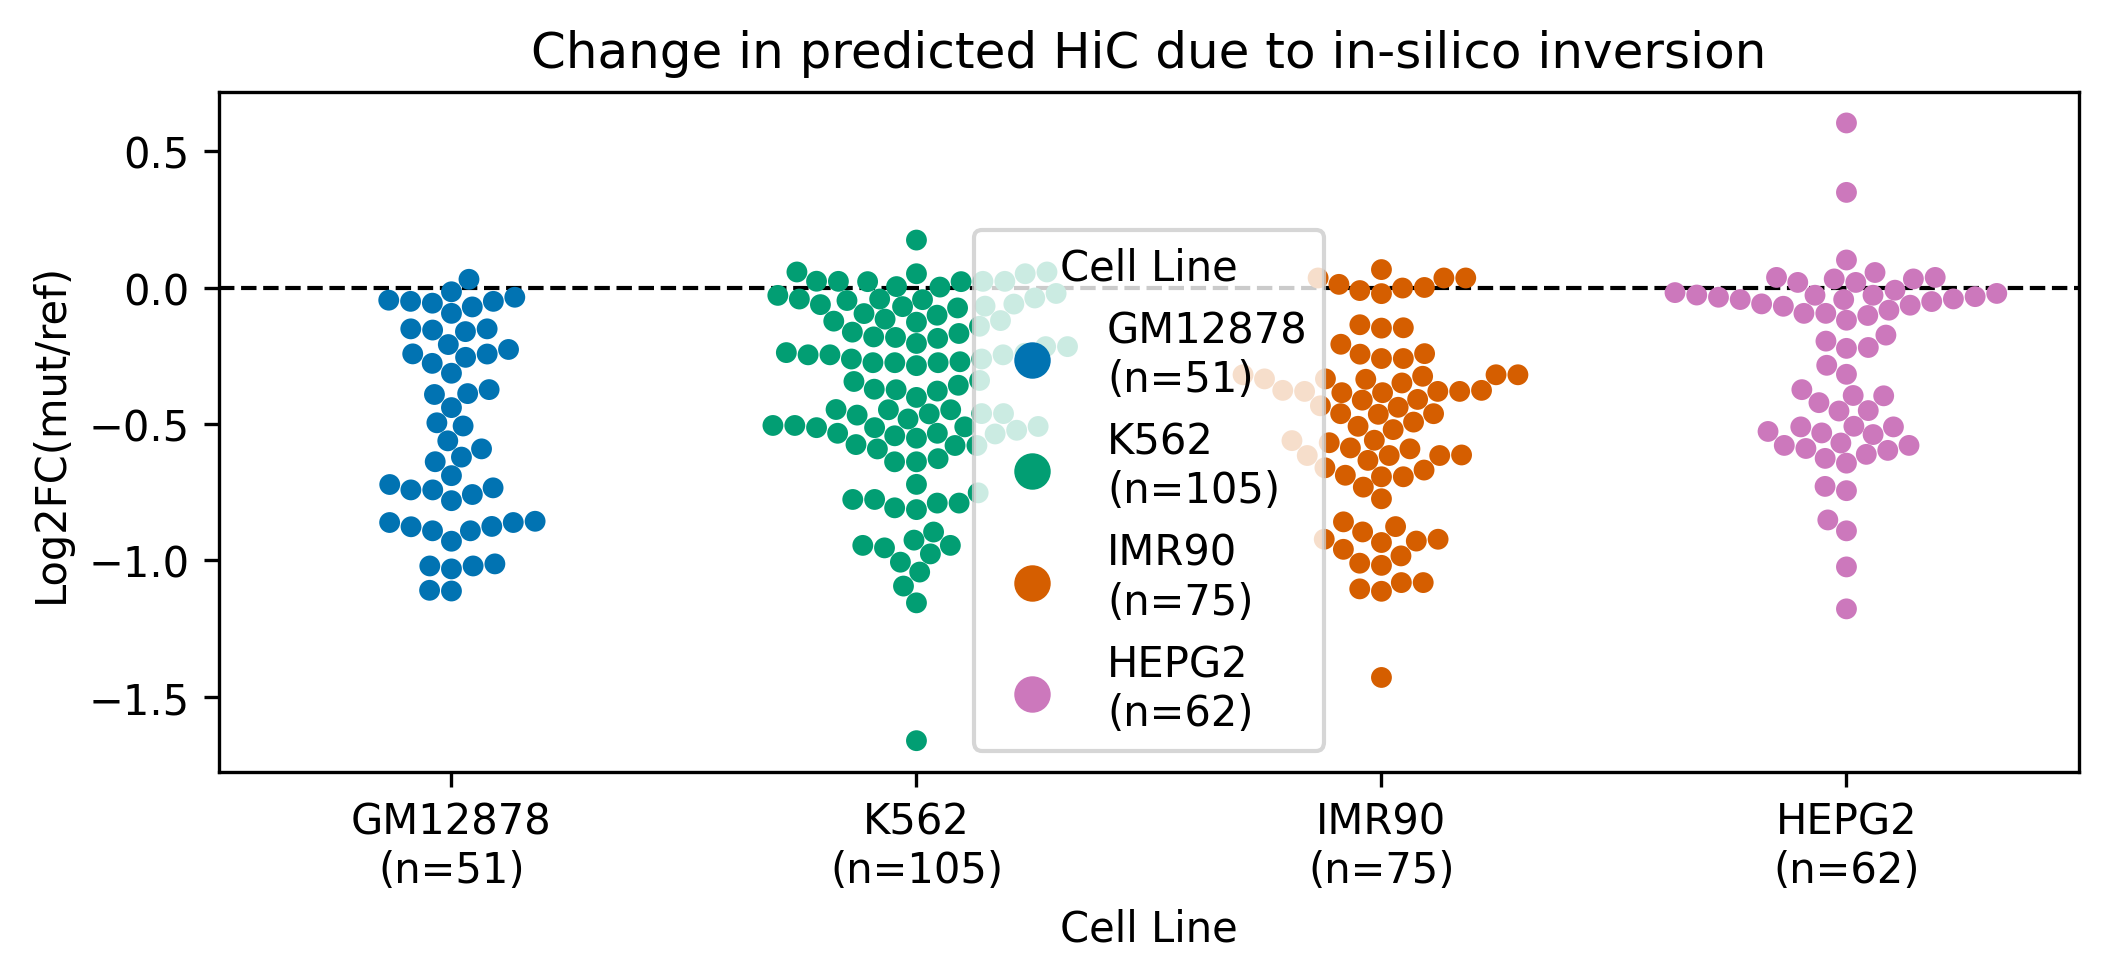

In [7]:
f, ax = plt.subplots(1,1,figsize=(8, 3),dpi=300)
sns.swarmplot(data=df, x='Cell Line', y="Log2FC(mut/ref)", hue='Cell Line', ax=ax)
plt.axhline(y=0, linestyle='--', linewidth=1, color='black')
title = 'Change in predicted HiC due to in-silico inversion'
plt.title(title)
plt.savefig(f'./plots/ism_unit_test.svg', format='svg', transparent=True)